In [1]:
# Importing packages

import pandas as pd
import numpy  as np
from sklearn.cluster import KMeans
import seaborn as sns
import datetime 
import chardet


Understanding Building Circularity
When working with these datasets, consider these key circularity concepts:

Material Connections: How materials are joined affects their potential for disassembly

- Mechanical connections (screws, bolts) typically allow easier separation
- Chemical connections (adhesives, mortars) may hinder material recovery
- Connection design directly impacts end-of-life reusability

End-of-Life Scenarios: Different materials have different potential pathways

Reuse: Direct application in new construction (highest value retention)
Recycling: Processing into new material (partial value retention)
Downcycling: Processing into lower-value applications
Disposal: Landfilling or incineration (lowest circularity value)
Environmental Indicators: Key metrics to consider include

Global Warming Potential (GWP)

# Goal 1: Automating Pollutant Assessment 
Current Situation: 
- ​To evaluate a material's reusability, users must manually input information about 
pollutants 
- ​These pollutants (adhesives, paints, fire retardants, etc.) affect how easily materials can 
be separated and reused 
- ​The manual nature of this process introduces inconsistency and inefficiency 



## Objective: Develop a system that automatically suggests strong default pollutant values based on the materials being assessed. 
This system should: 
- ​Predict likely pollutants based on material combinations 
- Provide appropriate pollutant classifications 
- Reduce manual input while improving assessment accuracy 

Analyzing material combinations in building components
Identifying connection types that support circular construction
Suggesting intuitive default connections between materials
Classifying connection types according to pollution potential

## Methodology and approach
- Machine learning models to predict pollutants based on material combinations 
- Pattern recognition systems that identify common construction methods and associated 
pollutants 
- Rule-based systems derived from expert knowledge 
- ​Default value frameworks with adjustment mechanisms based on material properties 

## Guiding Questions

1. How can we identify which materials are commonly used together in building components?
2. What properties in the datasets can help us determine the type of connections used between materials?
3. How might different connection types affect the end-of-life scenarios in the tBaustoff dataset?
4. Can we classify connections based on their environmental impact using the lifecycle assessment data?
5. What metrics could we use to define the "disturbance potential" of different connection types?
6. How can we develop a recommendation system for material connections that optimizes for circularity?

## to have in mind

When working with these datasets, consider these key circularity concepts:

Material Connections: How materials are joined affects their potential for disassembly 
- Mechanical connections (screws, bolts) typically allow easier separation
- Chemical connections (adhesives, mortars) may hinder material recovery
- Connection design directly impacts end-of-life reusability

End-of-Life Scenarios: Different materials have different potential pathways

- Reuse: Direct application in new construction (highest value retention)
- Recycling: Processing into new material (partial value retention)
- Downcycling: Processing into lower-value applications
- Disposal: Landfilling or incineration (lowest circularity value)


# Data Wrangling

## Data Extraction

In [2]:
# detect files encoding
with open("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/OBD_2024_I.csv", "rb") as f:
    result = chardet.detect(f.read(100000))  # Read first 100,000 bytes
    print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.7295400999999999, 'language': ''}


In [3]:
# Importing data from CSV and converting to dataframe
oko_2024_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/OBD_2024_I.csv", delimiter=";", encoding = result["encoding"], low_memory=False)
oko_2023_df= pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/OBD_2023_I.csv", delimiter=";", encoding = result["encoding"], low_memory=False)
oko_2020_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/OBD_2020_II.csv", delimiter=";", encoding = result["encoding"], low_memory=False)
tbau_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/tBaustoff_with_OBD_mapping.csv", delimiter=";", encoding = result["encoding"], low_memory=False)


Notes on ÖKOBAUDAT Data:

Each dataset contains environmental impact indicators organized by lifecycle phases
Material entries include detailed technical specifications and reference quantities
Data follows standardized categories based on international norms (EN 15804)
UUID identifiers ensure consistent referencing across different datasets

The database follows the European Standard EN 15804+A2 for sustainable building assessment, which is additionally reflected in the column names of the Environmental Impact Indicators (`(A2)` postfix in the column name). Impact values can be positive (environmental burden) or negative (environmental credit).

The [`ÖKOBAUDAT`](https://www.oekobaudat.de/en.html) is Germany's standardized database for ecological evaluations of buildings by the [Federal Ministry for Housing, Urban Development and Building (BMWSB)](https://www.bmwsb.bund.de/Webs/BMWSB/DE/startseite/startseite-node.html). At its core lies the life cycle assessment (LCA) data on building materials, construction, transport, energy and disposal processes. 

Note that data entries in `ÖKOBAUDAT` are referred to as *Processes*, not materials, as life cycle assessment is conducted at the process level. If you see a reference to a *Process* in connection with `ÖKOBAUDAT`, it means that the data is related to a speficic material combined with assessments through its entire life cycle.

The dataset contains multiple rows for the same material. To understand why there are duplicates, let's pay attention to the ``Modul`` column -- it indicates the lifecycle stage of the material. So, each dataset represents environmental impacts across different life cycle stages:


- **A**: production, transport and installation phase
- **B**: use phase
- **C**: deconstruction and disposal phase    
- **D**: recycling potential and benefits

and the environmental impact of the material varies from one stage to another. The technology description on the website contains more contextual information.

![Copper sheet lifecycle](img/copper_tech_description.png)

Unfortunately, it also looks like a lot of the data is still missing (``NaN``'s in the dataframe). However, the amount of data varies from one material to another. You also won't need all the data for the challenge. We'll select the columns that are most relevant; however, feel free to explore the data further.

In [4]:
# detect files encoding for pollutant_combinations.csv
with open("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/pollutant_combinations.csv", "rb") as f:
    result = chardet.detect(f.read(100000))  # Read first 100,000 bytes
    print(result)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [5]:
# importing pullutant_combinations.csv
pollutants_df = pd.read_csv("/Users/pablosoriano/Documents/Data Science/bbsr-challenge/csv/pollutant_combinations.csv", delimiter=",", encoding = result["encoding"], low_memory=False)

In [6]:
# Assesing if to merge the dataframes or just keep the one from 2024

# Compare unique material names between datasets
materials_2020 = set(oko_2020_df["Name (en)"].dropna().unique())
materials_2023 = set(oko_2023_df["Name (en)"].dropna().unique())
materials_2024 = set(oko_2024_df["Name (en)"].dropna().unique())

# Find materials in 2020 and 2023 that are not in 2024
unique_2020 = materials_2020 - materials_2024
unique_2023 = materials_2023 - materials_2024

# Count them
unique_2020_count = len(unique_2020)
unique_2023_count = len(unique_2023)

unique_2020_count, unique_2023_count


(262, 546)

There are materials in previous datasets that are not present in the 2024 dataset:

2020 has 262 materials not found in 2024.
2023 has 546 materials not found in 2024.

This means that the 2024 dataset is not a full replacement — it doesn’t include all materials from earlier versions.

For maximum coverage (e.g. all materials ever documented), we should consider including previous years.

In [30]:
# in german
# Assesing if to merge the dataframes or just keep the one from 2024

# Compare unique material names between datasets
materials_2020 = set(oko_2020_df["Name (de)"].dropna().unique())
materials_2023 = set(oko_2023_df["Name (de)"].dropna().unique())
materials_2024 = set(oko_2024_df["Name (de)"].dropna().unique())

# Find materials in 2020 and 2023 that are not in 2024
unique_2020 = materials_2020 - materials_2024
unique_2023 = materials_2023 - materials_2024

# Count them
unique_2020_count = len(unique_2020)
unique_2023_count = len(unique_2023)

unique_2020_count, unique_2023_count



(519, 585)

In [7]:
# merging the datasets

# Add a source column for reference
oko_2020_df["source_year"] = 2020
oko_2023_df["source_year"] = 2023
oko_2024_df["source_year"] = 2024

# Combine all datasets
oko_combined_df = pd.concat([oko_2020_df, oko_2023_df, oko_2024_df], ignore_index=True)

In [8]:
# Sort by source year descending to keep the latest entry in case of duplicates
combined_df_sorted = oko_combined_df.sort_values(by="source_year", ascending=False)


In [ ]:
# Drop duplicates keeping the latest version (based on UUID, Version, Modul)
deduped_df = combined_df_sorted.drop_duplicates(subset=["UUID", "Version", "Modul"], keep="first") # could think of replace "UUID with "Name (de)" or "Name (en)" to keep the latest version of the name

# Reset index and show result
deduped_df.reset_index(drop=True, inplace=True)

## Data Cleaning

In [10]:
# Identifying the columns with missing values
missing_values = deduped_df.isnull().sum()

In [11]:
missing_values

UUID                        0
Version                     0
Name (de)                2886
Name (en)                2953
Kategorie (original)        0
                        ...  
WDP (A2)                 9405
Unnamed: 79             25665
source_year                 0
Stueckgewicht (kg)      25477
Unnamed: 80             25665
Length: 83, dtype: int64

In [12]:
# Calculate percentage of missing values per column
null_percentage = deduped_df.isnull().mean().sort_values(ascending=False)

# Select columns with more than 90% missing values
high_null_cols = null_percentage[null_percentage > 0.9]
high_null_cols

URL des Vorgängers        1.000000
Unnamed: 80               1.000000
Unnamed: 79               1.000000
Stueckgewicht (kg)        0.992675
Ergiebigkeit (m2)         0.987064
Schuettdichte (kg/m3)     0.986090
Laengengewicht (kg/m)     0.941126
Version des Vorgängers    0.937502
dtype: float64

These columns have extremely low data coverage and are unlikely to offer analytical value without substantial data imputation or external sourcing. Dropping them will simplify the dataset and reduce noise without significant information loss.

Unnamed: 80 and URL des Vorgängers are completely empty → should be dropped.


In [13]:
# Drop the columns with >90% missing values
columns_to_drop = [
    "Unnamed: 80", "Unnamed: 79", "URL des Vorgängers",
    "Stueckgewicht (kg)", "Ergiebigkeit (m2)", "Schuettdichte (kg/m3)",
    "Laengengewicht (kg/m)", "Version des Vorgängers"
]

cleaned_df = deduped_df.drop(columns=columns_to_drop)

Missing values of Environmental Impact Indicators (EN 15804+A1 and +2)

Understanding the EN 15804 Standard and Its Impact on LCA Calculations
The EN 15804 standard is the foundation for Environmental Product Declarations (EPDs) worldwide. In 2019, a significant update (EN 15804+A2) was released, becoming mandatory in July 2022. This update changes how environmental impacts are measured in EPDs.

What Changed?
While the environmental impact categories (like global warming and ozone depletion) are mostly the same, the units used to measure them have changed. This means that older EPDs (EN 15804+A1) cannot be directly compared or used with newer EPDs (EN 15804+A2) in LCA calculations.

How does this affect Building LCA?
Simply put, you can't mix and match old and new EPDs in your building LCA calculations.

Since 15804+A1 has a big % of missing values and it's out of use, I will evaluate drop the whole columns unless they have values that are not covered in +A2



In [14]:
# Define A1 and A2 column groups
a1_columns = ["GWP", "ODP", "POCP", "AP", "EP", "ADPE", "ADPF"]
a2_columns = [
    "GWPtotal (A2)", "GWPbiogenic (A2)", "GWPfossil (A2)", "GWPluluc (A2)",
    "ODP (A2)", "POCP (A2)", "AP (A2)", "EPmarine (A2)", "EPfreshwater (A2)", 
    "EPterrestrial (A2)", "ADPE (A2)", "ADPF (A2)"
]

# Check for non-null rows in A1 indicators
a1_non_null = (cleaned_df[a1_columns].notnull().sum()).sort_values(ascending=False)

# Check for any A1 values that do not have A2 counterparts in the same row
# Simplest heuristic: check if A1 column is filled but all A2s are null for that row
rows_with_only_a1 = cleaned_df[a1_columns].notnull().any(axis=1) & (~cleaned_df[a2_columns].notnull().any(axis=1))

# Count how many rows this applies to
only_a1_count = rows_with_only_a1.sum()

a1_non_null, only_a1_count


(GWP     8294
 ODP     8281
 POCP    8281
 AP      8281
 ADPE    8281
 EP      8279
 ADPF    8277
 dtype: int64,
 np.int64(8294))

Interpretation: These A1 values are not duplicated or represented in the A2 columns — they are unique to older datasets.
Therefore, dropping them would result in data loss for ~8,300 records.

## Data Transformation

In [15]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25665 entries, 0 to 25664
Data columns (total 75 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   UUID                                           25665 non-null  object 
 1   Version                                        25665 non-null  object 
 2   Name (de)                                      22779 non-null  object 
 3   Name (en)                                      22712 non-null  object 
 4   Kategorie (original)                           25665 non-null  object 
 5   Kategorie (en)                                 25665 non-null  object 
 6   Konformität                                    25665 non-null  object 
 7   Laenderkennung                                 25659 non-null  object 
 8   Typ                                            25665 non-null  object 
 9   Referenzjahr                                   256

In [16]:
# Convert numeric columns (A2 environmental indicators and other relevant ones) from string to float
# We'll replace commas with dots and coerce errors to NaN

numeric_cols = [
    "Referenzjahr", "Gueltig bis","Bezugsgroesse", "Bezugseinheit ","Rohdichte (kg/m3)","Flaechengewicht (kg/m2)","Schichtdicke (m)", "Umrechungsfaktor auf 1kg","biogener Kohlenstoffgehalt in kg","biogener Kohlenstoffgehalt (Verpackung) in kg","GWP", "ODP", "POCP", "AP", "EP", "ADPE", "ADPF","PERE", "PERM", "PERT", "PENRE", "PENRM", "PENRT",
    "SM", "RSF", "NRSF", "FW", "HWD", "NHWD", "RWD", "CRU", "MFR", "MER", "EEE", "EET",
    "AP (A2)", "GWPtotal (A2)", "GWPbiogenic (A2)", "GWPfossil (A2)", "GWPluluc (A2)",
    "ETPfw (A2)", "PM (A2)", "EPmarine (A2)", "EPfreshwater (A2)", "EPterrestrial (A2)",
    "HTPc (A2)", "HTPnc (A2)", "IRP (A2)", "SOP (A2)", "ODP (A2)", "POCP (A2)",
    "ADPF (A2)", "ADPE (A2)", "WDP (A2)"
]

# Convert all columns listed above 
for col in numeric_cols:
    if col in cleaned_df.columns:
        cleaned_df[col] = cleaned_df[col].astype(str).str.replace(",", ".").str.strip()
        cleaned_df[col] = pd.to_numeric(cleaned_df[col], errors='coerce')

# Convert date column to datetime
if "Veroeffentlicht am" in cleaned_df.columns:
    cleaned_df["Veroeffentlicht am"] = pd.to_datetime(cleaned_df["Veroeffentlicht am"], errors='coerce')

# Convert Referenzjahr and Gueltig bis to integer 
cleaned_df["Referenzjahr"] = cleaned_df["Referenzjahr"].dropna().astype("Int64")
cleaned_df["Gueltig bis"] = cleaned_df["Gueltig bis"].dropna().astype("Int64")

- Numeric columns were converted from string (with commas) to proper float types.

- Date column Veroeffentlicht am is now in datetime format.

- Year columns like Referenzjahr and Gueltig bis were converted to integer type where possible.

In [17]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25665 entries, 0 to 25664
Data columns (total 75 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   UUID                                           25665 non-null  object        
 1   Version                                        25665 non-null  object        
 2   Name (de)                                      22779 non-null  object        
 3   Name (en)                                      22712 non-null  object        
 4   Kategorie (original)                           25665 non-null  object        
 5   Kategorie (en)                                 25665 non-null  object        
 6   Konformität                                    25665 non-null  object        
 7   Laenderkennung                                 25659 non-null  object        
 8   Typ                                            25665 non

#REVIEW - Was thinking of imputing missing values of A2 columns with the median for category and module, but two materials in the same Kategorie (en) and Modul can differ a lot in their environmental impact or circularity, especially depending on:

- Production method (e.g., recycled vs virgin)
- Geographic source (local vs imported)
- Manufacturer-specific practices
- Declared unit or functional equivalence

Let's check if we can impute this values from other sources

## Data Enrichment

In [18]:
# Helper column classifying the environmental impact standard
def classify_impact_standard(row):
    has_a1 = row[a1_columns].notnull().any()
    has_a2 = row[a2_columns].notnull().any()
    if has_a1 and not has_a2:
        return "A1"
    elif has_a2 and not has_a1:
        return "A2"
    elif has_a1 and has_a2:
        return "mixed"
    else:
        return "none"

# Apply the function
cleaned_df["impact_standard"] = cleaned_df.apply(classify_impact_standard, axis=1)

# Show counts for each category
impact_counts = cleaned_df["impact_standard"].value_counts()

impact_counts


impact_standard
A2      16260
A1       8294
none     1111
Name: count, dtype: int64

In [28]:
# importing as csv
cleaned_df.to_csv("obd_merged.csv", sep=";", index=False, encoding="utf-8-sig")

### Grouping high cardinality categorical variables

Why Group High-Cardinality Categorical Variables?

- Simplifies the Data
- Some text columns may have hundreds of unique values but little analytical meaning (e.g., slight naming variations).
- Improves Interpretability
- Creating higher-level groupings makes it easier to see patterns (e.g., grouping brands, regions, or dataset types).
- Reduces Noise in Visualizations/Models
- Too many categories can overwhelm bar charts or lead to sparse dummy variables in ML models.

In [19]:
# Filter the DataFrame for object columns
non_numeric = cleaned_df.select_dtypes("object")

# Loop through columns
for x in non_numeric.columns:
    # Print the number of unique values
    print(f"Number of unique values in {x} column: ", non_numeric[x].nunique())

cleaned_df

Number of unique values in UUID column:  3863
Number of unique values in Version column:  118
Number of unique values in Name (de) column:  2459
Number of unique values in Name (en) column:  2495
Number of unique values in Kategorie (original) column:  264
Number of unique values in Kategorie (en) column:  265
Number of unique values in Konformität column:  16
Number of unique values in Laenderkennung column:  42
Number of unique values in Typ column:  5
Number of unique values in URL column:  3984
Number of unique values in Declaration owner column:  439
Number of unique values in Registrierungsnummer column:  1567
Number of unique values in Registrierungsstelle column:  11
Number of unique values in UUID des Vorgängers column:  809
Number of unique values in Bezugseinheit column:  9
Number of unique values in Referenzfluss-UUID column:  2549
Number of unique values in Referenzfluss-Name column:  2280
Number of unique values in Modul column:  18
Number of unique values in Szenario col

,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,...,HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2),source_year,impact_standard
0,3501e11c-2909-4e3f-a976-2fa82c86e803,00.00.009,Claytec Mineral 20 trocken,Claytec Mineral 20 dried,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022,...,NaN,NaN,NaN,-2.549346e-06,-2.049393e-05,-0.462753,-4.342871e-07,-0.000162,2024,A2
1,00fe2655-02ad-4ded-925a-af9b8f1a27c8,00.00.015,FASBA e.V. Baustroh 100 kg/m³,FASBA e.V. Baustroh 100 kg/m³ GaBi - 2024,'Dämmstoffe' / 'Stroh' / 'Strohballen','Insulation materials' / 'Straw' / 'Straw bale','EN 15804+A2 (EF 3.1)' / 'ISO 14025',DE,specific dataset,2024,...,-1.931275e-07,-0.164974,-11.855288,-3.539990e-11,-1.033700e-02,-441.423176,-8.462049e-07,-0.055600,2024,A2
2,00fe2655-02ad-4ded-925a-af9b8f1a27c8,00.00.015,FASBA e.V. Baustroh 100 kg/m³,FASBA e.V. Baustroh 100 kg/m³ GaBi - 2024,'Dämmstoffe' / 'Stroh' / 'Strohballen','Insulation materials' / 'Straw' / 'Straw bale','EN 15804+A2 (EF 3.1)' / 'ISO 14025',DE,specific dataset,2024,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,2024,A2
3,00fe2655-02ad-4ded-925a-af9b8f1a27c8,00.00.015,FASBA e.V. Baustroh 100 kg/m³,FASBA e.V. Baustroh 100 kg/m³ GaBi - 2024,'Dämmstoffe' / 'Stroh' / 'Strohballen','Insulation materials' / 'Straw' / 'Straw bale','EN 15804+A2 (EF 3.1)' / 'ISO 14025',DE,specific dataset,2024,...,2.743039e-08,0.238850,16.740538,5.242030e-11,2.433899e-02,24.347930,3.594269e-07,0.219631,2024,A2
4,3501e11c-2909-4e3f-a976-2fa82c86e803,00.00.009,Claytec Mineral 20 trocken,Claytec Mineral 20 dried,'Mineralische Baustoffe' / 'Mörtel und Beton' ...,'Mineral building products' / 'Mortar and Conc...,'EN 15804+A2 (EF 3.0)' / 'PCR Ökobilanzierung ...,DE,specific dataset,2022,...,NaN,NaN,NaN,8.308000e-05,3.862000e-11,0.199900,6.946000e-07,0.001645,2024,A2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25660,34f8d4b9-2ff3-4ca3-aab0-d52c6e455f71,00.00.013,Isospan 1 GaBi Holzbetonmantelsteine mit Holzf...,NaN,'Mineralische Baustoffe' / 'Steine und Element...,"'Mineral building products' / 'Bricks, blocks ...",'EN 15804' / 'ISO 14025',AT,specific dataset,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25661,34f8d4b9-2ff3-4ca3-aab0-d52c6e455f71,00.00.013,Isospan 1 GaBi Holzbetonmantelsteine mit Holzf...,NaN,'Mineralische Baustoffe' / 'Steine und Element...,"'Mineral building products' / 'Bricks, blocks ...",'EN 15804' / 'ISO 14025',AT,specific dataset,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25662,8d06b1df-e898-4009-adee-57ca44aaafcc,00.05.000,BauderTHERMOFOL,BauderTHERMOFOL U / M,'Kunststoffe' / 'Dachbahnen' / 'PVC-Dachbahnen','Plastics' / 'Roofing membranes' / 'PVC sheet','DIN EN 15804' / 'ISO 14025',DE,average dataset,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1
25663,d4680073-0c9c-40f4-842f-c6830856812c,00.03.000,Betonpflaster- Standardstein grau mit Vorsatz,NaN,'Mineralische Baustoffe' / 'Steine und Element...,"'Mineral building products' / 'Bricks, blocks ...",'DIN EN 15804' / 'ISO 14025',DE,average dataset,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,A1


#TODO - create categories for numerical columns



Advantages of Binning A2 Metrics

Simplicity and Interpretability:
Transforming continuous values into categorical bins (low, medium, high) can make it easier to communicate results, especially when discussing environmental impacts with stakeholders who may not be familiar with the detailed numerical scales.

Mitigation of Outliers:
Binning helps by reducing the impact of outliers. This is particularly useful in environmental data, where extreme values may unduly influence the learning process.

Handling Non-Linear Relationships:
If the relationship between your input features and the target pollutant classifications is non-linear, discretizing continuous features can sometimes help the model capture these patterns more effectively, especially with models that perform better with categorical inputs.

How to Determine Binning Thresholds
Official or Domain-Specific Thresholds:
Check if there are established thresholds in environmental impact studies or standards like EN 15804 or related sustainable building guidelines. Although EN 15804+A2 doesn’t always prescribe discrete bins, you might find reference values in literature or national sustainable building frameworks.

Data-Driven Methods:

Quantile-Based Binning:
You could divide your data into bins based on percentiles (for example, using the 33rd and 67th percentiles to create three bins). This approach adapts naturally to the distribution of your data.

Clustering Techniques:
Methods like k-means clustering on each metric can help identify natural groupings in the data, which may correspond to low, medium, and high categories.

Equal-Width Binning:
Dividing the range of values into equal intervals is a simple method, though it might not capture the underlying data distribution as effectively as quantile-based methods.

Expert-Defined Thresholds:
Collaborate with domain experts to set thresholds based on practical experience or guidelines from sustainability frameworks. Their insights can help ensure that the bins are meaningful in the context of environmental impact assessment.

Implementation Considerations
Trial and Validation:
It may be beneficial to experiment with multiple binning strategies and evaluate the performance of your ML model on each. This allows you to find the right balance between granularity and interpretability.

Preservation of Information:
Although binning simplifies the data, it inherently loses some information. Consider whether your downstream model benefits more from a simplified categorical input or if it would perform better with the raw continuous data. You might even consider an ensemble approach where both binned and continuous features are used.

Documentation:
Clearly document the thresholds and the reasoning behind the chosen binning strategy. This not only supports the reproducibility of your work but also adds transparency to your decision-making process in the model development lifecycle.

Conclusion
Yes, binning the values of your A2 impact metrics into categories such as low, medium, and high makes sense—it can lead to a more robust, interpretable, and possibly even more performant model. The next step would be to experiment with different binning strategies (quantile-based, equal-width, or domain-informed thresholds) and assess their impact on your model’s performance.



In [20]:
# Clustering trial for a random column

clustering_df = cleaned_df.copy()

clustering_df.dropna(subset= "AP (A2)", inplace=True)

# Reshape the column to (-1, 1) for KMeans clustering
X = clustering_df["AP (A2)"].values.reshape(-1, 1)  # or use cleaned_df[['GWPtotal (A2)']].values
# data[['GWPtotal (A2)']].values

# Set up and fit k-means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_df['cluster'] = kmeans.fit_predict(X)

# Determine the order of clusters by their center values (ascending)
cluster_centers = kmeans.cluster_centers_.flatten()
# Create a mapping from cluster index to bin label based on sorted cluster centers
sorted_clusters = np.argsort(cluster_centers)
cluster_label_mapping = {sorted_clusters[0]: "Low", sorted_clusters[1]: "Medium", sorted_clusters[2]: "High"}

# Map the cluster labels to human-readable bins
clustering_df['GWPtotal_kmeans_bins'] = clustering_df['cluster'].map(cluster_label_mapping)

print("K-Means Clustering Binning Example:")
print(clustering_df[['GWPtotal (A2)', 'cluster', 'GWPtotal_kmeans_bins']].head())



K-Means Clustering Binning Example:
   GWPtotal (A2)  cluster GWPtotal_kmeans_bins
0      -0.027893        0               Medium
1      -7.504680        0               Medium
2       0.000000        0               Medium
3     150.421488        0               Medium
4       0.014589        0               Medium


Negative values for Acidification Potential (AP) in EN 15804+A2 are normal and can occur due to the inclusion of "Module D" credits, such as those from steel recycling or wood carbon sequestration. These credits essentially represent environmental benefits, leading to a reduction in the overall impact, which can result in negative values for the total AP, according to calculatelca.com. 


In [21]:
clustering_df.groupby("GWPtotal_kmeans_bins").size().reset_index(name="count")

,GWPtotal_kmeans_bins,count
0,High,2
1,Low,2
2,Medium,16256


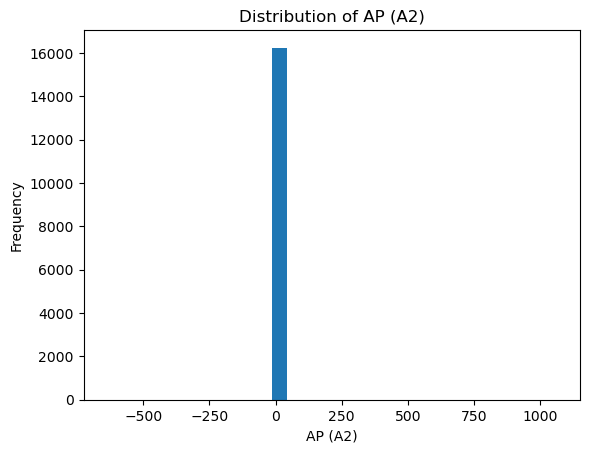

In [22]:
import matplotlib.pyplot as plt

plt.hist(clustering_df["AP (A2)"], bins=30)
plt.xlabel("AP (A2)")
plt.ylabel("Frequency")
plt.title("Distribution of AP (A2)")
plt.show()

In [23]:
print("min AP value :",clustering_df["AP (A2)"].min())
print("max AP value :",clustering_df["AP (A2)"].max())

min AP value : -639.733086415319
max AP value : 1063.9696132234


1. Context and Variability in AP Values

Acidification Potential (AP) as defined by EN 15804+A2 is usually expressed in terms of “Mole of H⁺ equivalents” per functional unit. Because AP depends on many factors such as the specific material, production process, and allocation methods, there isn’t a single, industry‐wide “official” range that applies to all construction products. Instead, published values vary considerably between product types:

Cement-Based Materials and Steel:
For many common materials (e.g., concrete, cement, and steel), AP values are often near zero or within a relatively narrow positive range. It’s not unusual to see values on the order of a few mole H⁺ eq per functional unit (or normalized per kg/m³, m², etc.).

Chemically Intensive or Recycled Materials:
Products that involve complex chemical processing (or where avoided burdens and system credits lead to net “negative” impacts) can report more extreme values. In some cases, values may be negative (indicating net credits) or very high if specific pollutants are significant.

2. What Do the Studies and Databases Show?

While there isn’t a single “official” average, several life cycle assessment (LCA) studies and databases (such as ecoinvent and Ökobaudat) have reported observations along these lines:

For Many Conventional Building Materials:
Research suggests that AP values are often found in a range from roughly –10 to +50 mole H⁺ eq (normalized to a common functional unit). This is typical for products like concrete, steel, and glass.

For Products with Special Treatments or Recycling Credits:
Some studies report AP values that can extend further—for example, values in the range of –50 to +150 mole H⁺ eq have been observed, especially when credits or avoided burdens are included in the assessment.

Note: These numbers are indicative. In the literature, you may also see narrower or wider ranges because of differences in LCA methodology, functional unit definitions, and allocation rules. In some cases, individual datasets may report values (like in your case) ranging from around –600 to +1000, which could reflect a mix of very low (or credited) impacts and outliers for certain material types.

In Summary
There isn’t one “official” average range for AP (A2) in the construction industry due to the wide variability among materials and methodologies. However, many LCA studies and databases suggest that for conventional building products, AP values often lie roughly in the range of –10 to +50 mole H⁺ eq, while more extreme products might fall between –50 and +150 mole H⁺ eq. The dataset’s range (–600 to 1000) indicates that it covers a broad spectrum of products, so it may be useful to use a hybrid, data-driven binning strategy that is also informed by domain knowledge.



When you use scikit-learn’s clustering algorithms like K-Means, they expect the input data to be in a two-dimensional array format where each row represents a sample and each column represents a feature. By default, when you extract a single column from a pandas DataFrame, you get a pandas Series, which is essentially a one-dimensional array with shape (n_samples,). Using .values.reshape(-1, 1) converts that Series into a two-dimensional numpy array with shape (n_samples, 1), which is the format expected by scikit-learn.

For example, if you simply do:

python
Copy
ap_values = df["AP (A2)"]
ap_values is a Series with shape (n_samples,), and K-Means might throw an error because it isn’t a 2D array. In contrast, doing:

python
Copy
ap_values = df["AP (A2)"].values.reshape(-1, 1)
creates an array where each sample is a row and there's one feature (the AP (A2) value) per row.

Using .reshape(-1, 1) tells numpy to infer the number of rows automatically (using -1) and explicitly set the number of columns to 1, ensuring compatibility with scikit-learn’s expectations.

## Data Validation

- The following columns where converted to numeric (float):

"Referenzjahr", "Gueltig bis","Bezugsgroesse", "Bezugseinheit ","Rohdichte (kg/m3)","Flaechengewicht (kg/m2)","Schichtdicke (m)", "Umrechungsfaktor auf 1kg","biogener Kohlenstoffgehalt in kg","biogener Kohlenstoffgehalt (Verpackung) in kg","GWP", "ODP", "POCP", "AP", "EP", "ADPE", "ADPF","PERE", "PERM", "PERT", "PENRE", "PENRM", "PENRT",
"SM", "RSF", "NRSF", "FW", "HWD", "NHWD", "RWD", "CRU", "MFR", "MER", "EEE", "EET",
"AP (A2)", "GWPtotal (A2)", "GWPbiogenic (A2)", "GWPfossil (A2)", "GWPluluc (A2)",
"ETPfw (A2)", "PM (A2)", "EPmarine (A2)", "EPfreshwater (A2)", "EPterrestrial (A2)",
"HTPc (A2)", "HTPnc (A2)", "IRP (A2)", "SOP (A2)", "ODP (A2)", "POCP (A2)",
"ADPF (A2)", "ADPE (A2)", "WDP (A2)"

- The Konformitat column has been summarized in two categories (A1, A2) in the column "impact_standard"

-  This columns where dropped: "Unnamed: 80", "Unnamed: 79", "URL des Vorgängers","Stueckgewicht (kg)", "Ergiebigkeit (m2)", "Schuettdichte (kg/m3)","Laengengewicht (kg/m)", "Version des Vorgängers"
(These columns have extremely low data coverage and are unlikely to offer analytical value without substantial data imputation or external sourcing. Dropping them will simplify the dataset and reduce noise without significant information loss.)

#REVIEW - Need to decide what to do with missing values! book an appointment with an expert

# EDA

In [25]:
# unique materials/processes in the dataset

print("unique names:",cleaned_df["Name (en)"].nunique()), 
print("unique moduls:",cleaned_df["Modul"].nunique())
print("unique UUID:", cleaned_df["UUID"].nunique())

unique names: 2495
unique moduls: 18
unique UUID: 3863


Note that data entries in `ÖKOBAUDAT` are referred to as *Processes*, not materials, as life cycle assessment is conducted at the process level. If you see a reference to a *Process* in connection with `ÖKOBAUDAT`, it means that the data is related to a speficic material combined with assessments through its entire life cycle.

In [27]:
# group by UUID and modul
cleaned_df.groupby(["UUID", "Modul"]).size().reset_index(name="count")

,UUID,Modul,count
0,00402f5e-4a5b-48a5-b1e2-cbd4fddffbe7,A1-A3,1
1,00402f5e-4a5b-48a5-b1e2-cbd4fddffbe7,C3,1
2,00402f5e-4a5b-48a5-b1e2-cbd4fddffbe7,C4,1
3,00402f5e-4a5b-48a5-b1e2-cbd4fddffbe7,D,1
4,00485255-d8a7-4e6d-b2ab-fba929e3cc4a,A1-A3,1
...,...,...,...
24666,ffeaa284-6f4a-452d-81c9-de28ab3b1dd7,B6,1
24667,ffff2074-fae0-4b5c-b801-af80f5ce633a,A1-A3,1
24668,ffff2074-fae0-4b5c-b801-af80f5ce633a,C2,1
24669,ffff2074-fae0-4b5c-b801-af80f5ce633a,C3,1


Each UUID has entries for different modules (lifecycle phases)

# Machine Learning